In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
pd.set_option('display.max_columns', None)

C:\Users\ly264\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ds_sample = pd.read_csv("DS_SAMPLE.csv")

In [3]:
ds_sample[0:5]

,TYPE,WHS,PO NUMBER,STORE FLG,CITY,STATE,VENDOR NUMBER,XDOCK FLG,TEMP FLG,PALLET,TOTAL CUBE,TOTAL CASES,TOTAL WGHT,CUBE,WEIGHT,TIXHI,SCHEDULE DATE,ITEM,UPC,FROM,TO,BYR,UNITS PER CASE,RANDOM WT,TRANS CODE,CREATION DATE
0,INBOUND - MASTER,197,28544,Y,CLIFTON,NJ,85579,R,D,31.82,1713.600,2100,63000.00,0.068,2.500,11-06-L,10/24/2019,2010015,76069500507,,,P47,12,N,T,9/16/2019
1,PASSTHROUGH,882,30779,Y,HARTFORD,CT,32569,R,D,1.00,52.560,60,1783.44,0.073,2.477,10-06-L,9/9/2019,430295,3120025900,,,P7E,12,N,P,8/23/2019
2,PASSTHROUGH,882,30779,Y,HARTFORD,CT,32569,R,D,0.17,8.280,10,283.44,0.069,2.362,10-06-L,9/9/2019,430021,3120025902,,,P7E,12,N,P,8/23/2019
3,PASSTHROUGH,882,30779,Y,HARTFORD,CT,32569,R,D,0.25,11.712,32,192.00,0.183,3.000,16-08-L,9/9/2019,2050120,3120021992,,,P7E,2,N,P,8/23/2019
4,PASSTHROUGH,882,30779,Y,HARTFORD,CT,32569,R,D,0.17,7.840,16,328.00,0.490,20.500,16-06-L,9/9/2019,52304,3120020450,,,P7E,0,N,P,8/23/2019


### Question 1

#### 1. For each "Type" in Column A:
A. What is the count of "PO NUMBER" by "WHS"?

In [4]:
q1a = ds_sample.groupby('WHS')['PO NUMBER'].count()\
        .reset_index()\
        .sort_values(by='PO NUMBER', ascending=False)
q1a.rename(columns={'PO NUMBER': 'PO NUMBER Count'}, inplace=True)
q1a[:5]

,WHS,PO NUMBER Count
16,197,423
10,163,279
44,895,274
43,882,219
12,171,216


B. What is the sum of "PALLET", "TOTAL CUBE", "TOTAL CASES", "TOTAL WGHT" by "VENDOR NUMBER"?

In [5]:
q1b = ds_sample.groupby('VENDOR NUMBER')[['PALLET', 'TOTAL CUBE', 'TOTAL CASES', 'TOTAL WGHT']].sum()
q1b

,PALLET,TOTAL CUBE,TOTAL CASES,TOTAL WGHT
VENDOR NUMBER,,,,
20000,1898.04,119515.941,103528,2929846.112
20120,63.00,2756.160,3024,124334.784
20547,48.00,2431.200,2400,105200.000
24269,1.00,48.960,96,2232.000
24291,35.73,1427.904,3216,84577.632
...,...,...,...,...
85734,20.24,1412.750,1090,40988.000
86083,24.00,3609.600,3840,128384.000
87001,18.98,661.200,1250,53640.000


#### 2. Using the "SCHEDULE DATE":
A. What is the mean of "PALLET" by day of the week?


In [6]:
ds_sample['SCHEDULE DATE'] = pd.to_datetime(ds_sample['SCHEDULE DATE'])
ds_sample["weekDay"] = ds_sample['SCHEDULE DATE'].dt.dayofweek
q2b = ds_sample.groupby('weekDay')['PALLET'].mean()\
      .to_frame()\
      .sort_values(by='PALLET', ascending=False)\
      
q2b.rename(columns={'PALLET': 'PALLET Average'}, inplace=True)
q2b['PALLET Average'] = round(q2b['PALLET Average'], 2)
q2b

,PALLET Average
weekDay,
6,10.09
5,4.35
4,1.16
2,1.05
0,0.90
1,0.85
3,0.51


 B. What is the average number of days between "CREATION DATE" & "SCHEDULE DATE"

In [7]:
ds_sample['CREATION DATE'] = pd.to_datetime(ds_sample['CREATION DATE'])
ds_sample['DateDiff'] = (ds_sample['SCHEDULE DATE'] - ds_sample['CREATION DATE']).dt.days
avg_days = ds_sample['DateDiff'].mean()

print("Average days between CREATION DATE & SCHEDULE DATE = {} day(s)".format(round(avg_days,0)))

Average days between CREATION DATE & SCHEDULE DATE = 13.0 day(s)


 C. Using the information calculated in B, identify rows that you consider to be "outliers". Please comment on how you decided on what is and is not an outlier.

 The first and simplest way to find an outlier is plot the pdf and visualize the data points. From the figure, we can generally know that date difference between "creation Date" & "Schedule Date" around 25-75 days might be an outlier. But it is not accuate. 

Text(0.5, 0, 'difference in dates')

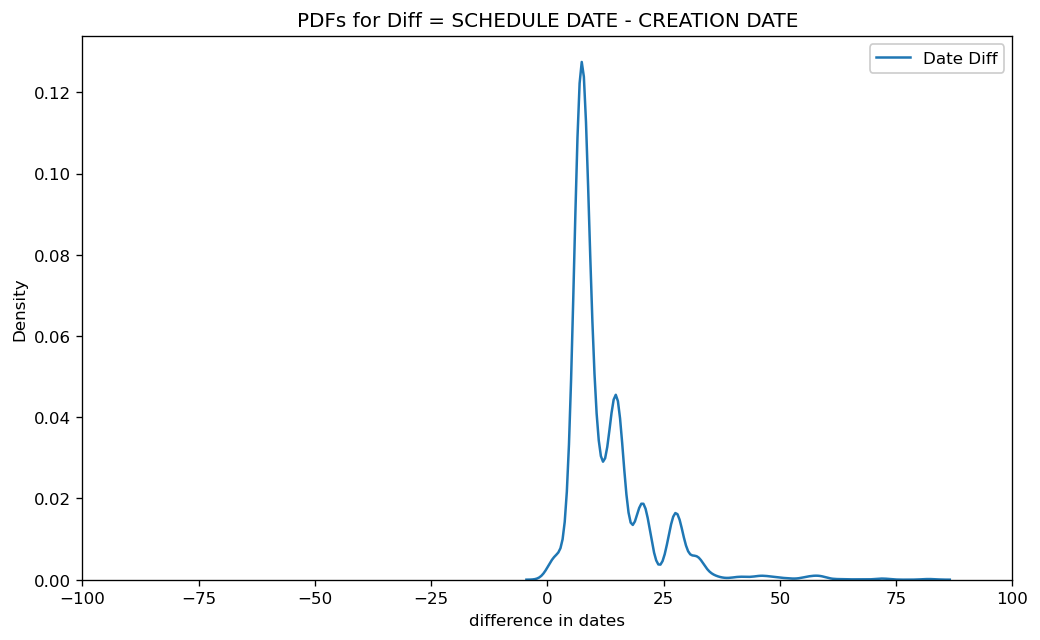

In [8]:
plt.figure(figsize=(10,6), dpi= 120)
sns.distplot(ds_sample['DateDiff'], kde=True, bins=60, hist=False, label='Date Diff')

plt.title('PDFs for Diff = SCHEDULE DATE - CREATION DATE', fontsize=12)
plt.legend(facecolor='white', framealpha=1)
plt.xlim(-100, 100)
plt.xlabel("difference in dates")

To better analze the outlier, I use box-whisker plot to indentify the outlier. The common statistical method of identify outlier is calulating quartile and the whisker lower limit and higher limit.

 The data points that smaller than the whisker lower limit value and greater than the whisker upper limit value are considered as outlier. Whikser lower limit = Q1-1.5 * IQR; upper limit = Q3+1.5 * IQR; Q1(lower quartile-first 25% of data) ; Q3(upper quartile--last 25% of the data); IQR(Interauartile Tnage = Q3-Q1);

In [14]:
def diff_boxplot(dataDic):
    whisker_dic = defaultdict(list)
    fig, ax = plt.subplots(figsize =(10, 6), dpi=120)
    ax.boxplot(dataDic.values(), patch_artist = True,
               notch ='True', showfliers=False)    
    ax.set_xticklabels(diff_dic.keys())
    ax.set_title("Difference = SCHEDULE DATE - CREATION DATE")
    ax.set_ylabel("difference in dates")
    keyL = list(dataDic.keys())
    for i, data in enumerate(dataDic.values()):
        median = np.median(data)
        
        ax.text(i+1+0.1, median-2, "median = {} days".format(median), fontsize=10)        
        upper_quartile = np.percentile(data, 75)
        ax.text(i+1+0.1, upper_quartile-2, "U quartile = {} days".format(upper_quartile), fontsize=10) 
        lower_quartile = np.percentile(data, 25)
        ax.text(i+1+0.1, lower_quartile-2, "L quartile = {} days".format(lower_quartile), fontsize=10) 
        
        iqr = upper_quartile - lower_quartile
        upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
        ax.text(i+1+0.1, upper_whisker-2, "U whisker = {} days".format(upper_whisker), fontsize=10) 
        whisker_dic[keyL[i]].append(upper_whisker)

        lower_whisker = data[data>=lower_quartile-1.5*iqr].min()
        ax.text(i+1+0.1, lower_whisker-2, "L whisker = {} days".format(lower_whisker), fontsize=10)
        whisker_dic[keyL[i]].append(lower_whisker)

        outlier_ct = len([v for v in data if (v > upper_whisker) | (v < lower_whisker)])
        print("{} - outlier pct = {}%".format(keyL[i], outlier_ct/len(data)*100))
    
    plt.show()
    return whisker_dic, upper_whisker, lower_whisker

dates_diff - outlier pct = 8.263020075647367%


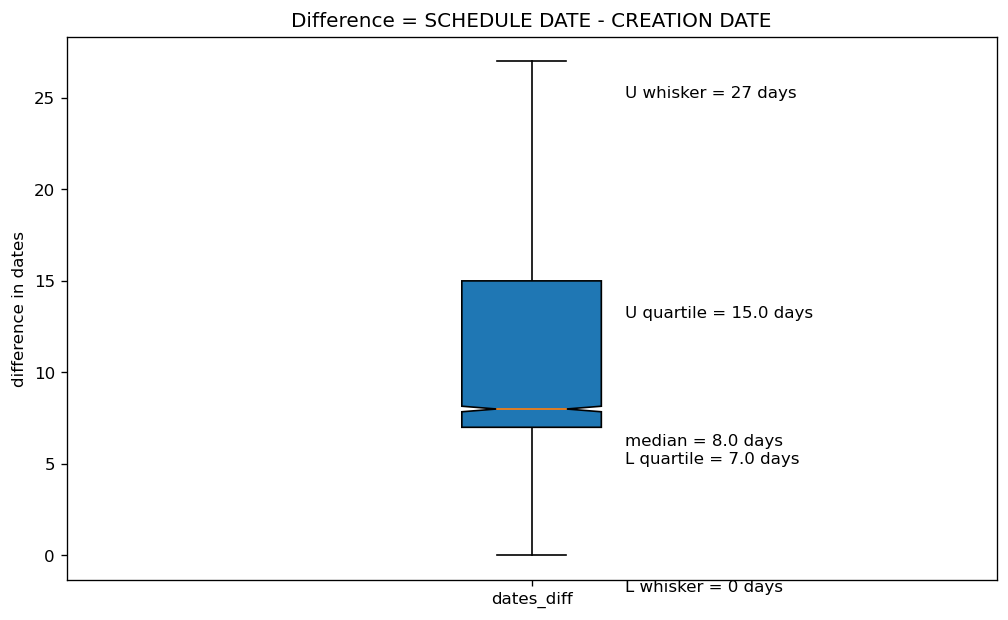

In [15]:
diff_dic = {'dates_diff': ds_sample['DateDiff']}
whisker_dic, upper_whisker, lower_whisker = diff_boxplot(diff_dic)

In [10]:
outier_df = ds_sample[(ds_sample['DateDiff'] < lower_whisker) | (ds_sample['DateDiff'] > upper_whisker)]
outier_df

,TYPE,WHS,PO NUMBER,STORE FLG,CITY,STATE,VENDOR NUMBER,XDOCK FLG,TEMP FLG,PALLET,TOTAL CUBE,TOTAL CASES,TOTAL WGHT,CUBE,WEIGHT,TIXHI,SCHEDULE DATE,ITEM,UPC,FROM,TO,BYR,UNITS PER CASE,RANDOM WT,TRANS CODE,CREATION DATE,DateDiff
0,INBOUND - MASTER,197,28544,Y,CLIFTON,NJ,85579,R,D,31.82,1713.600,2100,63000.0,0.068,2.50,11-06-L,2019-10-24,2010015,76069500507,,,P47,12,N,T,2019-09-16,38
8,INBOUND - MASTER,197,28544,Y,CLIFTON,NJ,85579,R,D,31.82,1713.600,2100,63000.0,0.068,2.50,11-06-L,2019-10-29,2010015,76069500507,,,P47,12,N,T,2019-09-16,43
9,INBOUND - MASTER,197,28648,Y,CLIFTON,NJ,85579,R,D,31.82,18648.000,2100,63000.0,0.740,2.50,11-06-L,2019-11-22,57516,76069500014,,,P47,12,N,T,2019-10-11,42
10,INBOUND - MASTER,197,28708,Y,CLIFTON,NJ,73705,R,D,22.00,1283.040,2376,59400.0,0.270,12.50,18-06-L,2019-12-19,23728,76069555402,,,P47,2,N,T,2019-10-24,56
11,INBOUND - MASTER,197,28533,Y,CLIFTON,NJ,86083,R,D,9.00,1353.600,1440,57744.0,0.470,20.05,16-10-L,2019-11-01,1780442,76069502654,,,P47,2,N,T,2019-09-12,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6676,PASSTHROUGH,895,55580,Y,SOUTH HACKENSACK,NJ,51400,R,D,0.10,4.947,17,96.9,0.291,5.70,17-10-L,2019-11-18,2490051,71909886641,,,P8X,0,N,T,2019-10-21,28
6677,PASSTHROUGH,895,55580,Y,SOUTH HACKENSACK,NJ,51400,R,D,0.10,4.600,20,119.2,0.230,5.96,20-10-L,2019-11-18,32554,76069500087,,,P8X,0,N,T,2019-10-21,28
6678,PASSTHROUGH,895,55580,Y,SOUTH HACKENSACK,NJ,51400,R,D,0.20,9.200,40,60.0,0.230,1.50,20-05-L,2019-11-18,32555,76069500083,,,P8X,0,N,T,2019-10-21,28
6807,INBOUND - MASTER,197,28667,Y,CLIFTON,NJ,42355,R,D,2.00,102.400,100,900.0,1.024,9.00,10-05-L,2019-11-18,490190,2409421103,,,P47,0,N,T,2019-10-15,34


D. Prepare a simple time series plot showing "TOTAL WGHT" over time

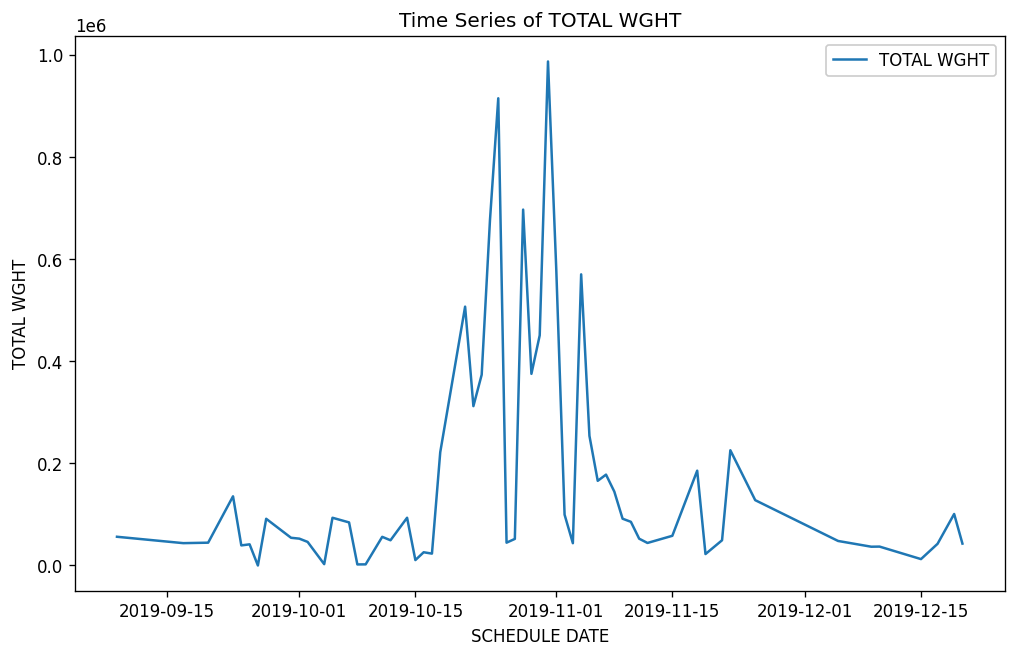

In [11]:
ts_df = ds_sample[['SCHEDULE DATE', 'TOTAL WGHT']].groupby('SCHEDULE DATE')['TOTAL WGHT'].sum().reset_index()
ts_df['SCHEDULE DATE'] = pd.to_datetime(ts_df['SCHEDULE DATE'])
ts_df.set_index('SCHEDULE DATE', inplace=True)

# Create a time series plot
plt.figure(figsize =(10, 6), dpi=120)
plt.plot(ts_df.index, ts_df['TOTAL WGHT'], label='TOTAL WGHT')
plt.xlabel('SCHEDULE DATE')
plt.ylabel('TOTAL WGHT')
plt.title('Time Series of TOTAL WGHT', fontsize=12)
plt.legend(facecolor='white', framealpha=1)

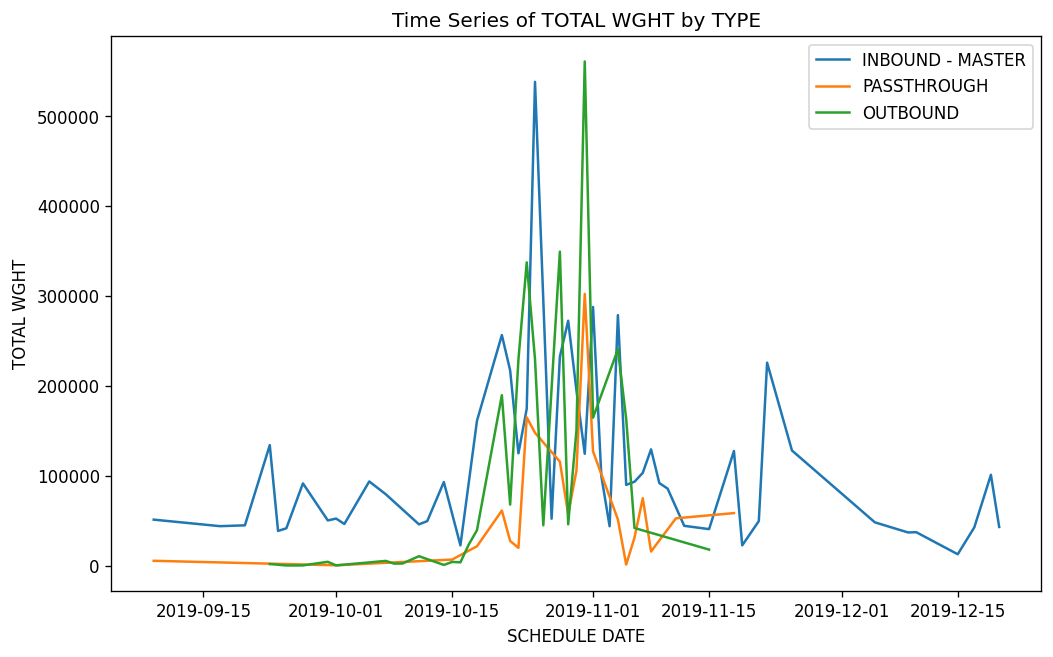

In [12]:
ts_df_alt = ds_sample[['SCHEDULE DATE', 'TYPE', 'TOTAL WGHT']].groupby(['SCHEDULE DATE','TYPE'])['TOTAL WGHT'].sum().reset_index()
ts_df_alt['SCHEDULE DATE'] = pd.to_datetime(ts_df_alt['SCHEDULE DATE'])
ts_df_alt.set_index('SCHEDULE DATE', inplace=True)

unique_types = ts_df_alt['TYPE'].unique()

plt.figure(figsize =(10, 6), dpi=120)
for type_ in unique_types:
    data = ts_df_alt[ts_df_alt['TYPE'] == type_]
    plt.plot(data.index, data['TOTAL WGHT'], label=type_)

plt.xlabel('SCHEDULE DATE')
plt.ylabel('TOTAL WGHT')
plt.title('Time Series of TOTAL WGHT by TYPE', fontsize=12)
plt.legend()
plt.show()

e. For every "BYR", identify the "UPC" with the most "TOTAL CASES" ordered across time

In [13]:
byr_df = ds_sample.groupby(['BYR', 'UPC'])['TOTAL CASES'].sum().reset_index()
q2e = byr_df.loc[byr_df.groupby('BYR')['TOTAL CASES'].idxmax()]\
      .sort_values(by='TOTAL CASES', ascending=False)
q2e

,BYR,UPC,TOTAL CASES
101,P47,76069500025,9778
564,P8X,72277622413,8020
424,P7E,76172005848,6750
509,P7J,9321504051,6336
8,P11,3606993996,1110
0,P04,5070000419,1080
15,P14,72277620002,525
519,P7V,7101211050,300
209,P4V,2060042684,252
18,P40,2354510427,152
